## Supratidal and Coastal Lowland connectivity model

In [1]:
import sys

import numpy as np
import xarray as xr
import geopandas as gpd

from odc.geo.gridspec import GridSpec
from odc.geo.geobox import GeoBox
from odc.geo.geom import BoundingBox
from odc.geo.types import xy_

import datacube
dc = datacube.Datacube()

from dea_tools.datahandling import load_reproject

sys.path.insert(1, "/home/jovyan/code/supratidal_forests/data")
from gridspec_96km_tiles import tiles

sys.path.insert(1, "/home/jovyan/code/supratidal_forests/functions")
from least_cost_path import xr_cost_distance, load_connectivity_mask_aquatic

### setup gridspec

In [2]:
# Expanded Extents 96 km tiling grid
gs_c3_expanded = GridSpec(
    crs="EPSG:3577",
    resolution=30,
    tile_shape=(3200, 3200),
    origin=xy_(-4416000, -6912000),
)

In [3]:
# Visualising whole grid
# Set bounding box
c3_bbox = BoundingBox(
    left=-2400000, bottom=-5088000, right=2784000, top=-864000, crs="EPSG:3577"
)

# Convert grid to geopandas polygon dataset covering full C3 grid extent
grid_gdf = gpd.GeoDataFrame.from_features(
    gs_c3_expanded.geojson(bbox=c3_bbox),
    crs="EPSG:4326", # CRS different here just for visualisation
)
grid_gdf.explore()

In [4]:
# User input, select tiles from list
print(tiles)

[(57, 60), (58, 60), (43, 59), (44, 59), (45, 59), (46, 59), (47, 59), (48, 59), (50, 59), (51, 59), (57, 59), (58, 59), (44, 58), (45, 58), (46, 58), (47, 58), (48, 58), (49, 58), (50, 58), (51, 58), (57, 58), (58, 58), (43, 57), (44, 57), (45, 57), (46, 57), (49, 57), (50, 57), (51, 57), (56, 57), (57, 57), (58, 57), (59, 57), (38, 56), (39, 56), (40, 56), (41, 56), (42, 56), (43, 56), (44, 56), (49, 56), (50, 56), (51, 56), (56, 56), (57, 56), (59, 56), (37, 55), (38, 55), (39, 55), (41, 55), (42, 55), (43, 55), (49, 55), (50, 55), (56, 55), (57, 55), (59, 55), (60, 55), (37, 54), (38, 54), (41, 54), (42, 54), (43, 54), (44, 54), (49, 54), (50, 54), (51, 54), (52, 54), (56, 54), (57, 54), (60, 54), (61, 54), (35, 53), (36, 53), (37, 53), (38, 53), (51, 53), (52, 53), (53, 53), (54, 53), (56, 53), (57, 53), (60, 53), (61, 53), (35, 52), (36, 52), (37, 52), (53, 52), (54, 52), (55, 52), (56, 52), (60, 52), (61, 52), (34, 51), (35, 51), (53, 51), (54, 51), (55, 51), (56, 51), (61, 51),

In [5]:
# Extract GeoBox for specific tile 
bbox = tiles[209]
geobox = gs_c3_expanded[bbox]  
geobox.explore()

### load in layers to make connectivity mask
- DEA mangroves
- JCU saltmarsh and saltflats
- CEM tidal Flats, Intertidal reefs and Intertidal rocky substratum (2), Mangroves (3), Saltmarsh (4), Intertidal Seagrass (5)

In [6]:
# Buffer input geobox and reduce resolution to ensure that the
# connectivity analysis is less affected by edge effects
buffer = 20000 # this is from load_connectivity_mask function. hardcoded here and will need to change if function value is change in load_connectivity_mask_aquatic
geobox_buffered = GeoBox.from_bbox(
    geobox.buffered(xbuff=buffer, ybuff=buffer).boundingbox,
    resolution=30,
    tight=True,
)

In [7]:
# Load srtm to buffered geobox
srtm_ds = dc.load(product = 'ga_srtm_dem1sv1_0', resampling="bilinear", like=geobox_buffered).squeeze()
srtm = srtm_ds.dem_h

# load in DEA mangroves
DEAmangrove = dc.load(product = 'ga_ls_mangrove_cover_cyear_3', time = ("2020", "2020"), like=geobox_buffered)
# if no mangroves within AOI, create dummy xr.dataarray
if DEAmangrove.data_vars == {}:
    mangrove = xr.DataArray(np.zeros_like(srtm), coords=srtm.coords, dims=srtm.dims, attrs=srtm.attrs)
else:
    # get output of mangrove == 1, not mangrove == 0
    mangrove = (DEAmangrove.canopy_cover_class != 255).squeeze('time')

# Load in JCU saltmarsh
geotiff_path = '/home/jovyan/gdata1/data/saltmarsh/JCU_Australia-saltmarsh-extent_v1-0.tif'
# load in geotiff again but with identical extent from srtm
saltmarsh = load_reproject(path=geotiff_path, how=geobox_buffered)

# Load in JCU saltflat
geotiff_path = '/home/jovyan/gdata1/data/saltmarsh/JCU_Australia-saltflat-extent_v1-0.tif'
# load in geotiff again but with identical extent from srtm
saltflat = load_reproject(path=geotiff_path, how=geobox_buffered)

# Load in CEM data (all except saltmarsh)
# CEM Saltmarsh layer will be load in separately
geotiff_path = '/home/jovyan/gdata1/projects/coastal/supratidal_forests/data/CEM_v002/ga_s2ls_coastalecosystems_cyear_3_2021--P1Y_interim_classification_0-0-2.tif'
CEM_data = load_reproject(path=geotiff_path, how=geobox_buffered)

CEM_layers = CEM_data.where((CEM_data == 2) | (CEM_data == 3) |(CEM_data == 5)) # all layers except saltmarsh
CEM = ~CEM_layers.isnull()

CEM_saltmarsh = CEM_data.where(CEM_data == 4) # saltmarsh in CEM equivalent to 4

# Saltmarsh intersection #
# Intersect both CEM and JCU saltmarsh layers based on common coordinates (inner join)
da_intersected = xr.align(CEM_saltmarsh, saltmarsh, join='inner')

# Extract the aligned DataArrays (now they share the same coordinates)
CEM_saltmarsh_aligned, saltmarsh_aligned = da_intersected

# Create a new DataArray based on the intersection (values aligned)
saltmarsh_intersection = CEM_saltmarsh_aligned + saltmarsh_aligned

saltmarsh_inter = ~saltmarsh_intersection.isnull()

In [8]:
# ocean nodata points
srtm_da = srtm == srtm.nodata

# combine masks for LCP, where 1 indicates aquatic features to start calculating LCP from, 0 are areas that will be given a LCP value
aquatic = xr.where((mangrove == True) | (saltmarsh_inter == True) | 
                   (saltflat == True) | (CEM == True) | (srtm_da == True), 1, 0).astype('bool')
aquatic = aquatic.compute()

/env/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


### run least cost path

In [9]:
# Run connectivity mask analysis
costdist_mask, costdist_da = load_connectivity_mask_aquatic(dc, geobox, starts_da = aquatic)

### generate connectivity probability product

In [10]:
# mask on srtm valid values (i.e. mask out ocean from costdist_da)
# Access nodata value from the DataArray attributes
nodata_value = srtm.attrs.get("nodata", None)

# Replace nodata values with np.nan if nodata_value is defined
if nodata_value is not None:
    srtm_masked = srtm.where(srtm != nodata_value, np.nan)
else:
    print("No nodata value found in attributes.")
# Apply the mask and ensure NaNs are propagated form srtm_masked
costdist_da_masked = costdist_da.where(~np.isnan(srtm_masked))

In [11]:
min_value = 0
max_value = 3118 #  New upper limit based on LCP for the upper Mary River field data 

# Clip values above max_value
costdist_da_clip = xr.where(costdist_da_masked > max_value, np.nan, costdist_da_masked.values)

In [12]:
# Define the exponential function y = e^(-0.004 * x)
def apply_exponential(arr):
    return np.exp(-0.004 * arr)

# Apply the exponential function to the pixel values of the costdist_da_clip
# no need to invert now from last code iteration
costdist_da_norm = apply_exponential(costdist_da_clip)

PosixPath('SCL_connectivity_model_x64y32.tif')

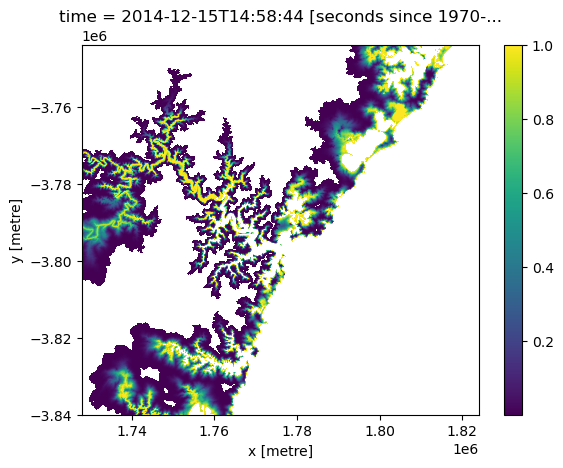

In [13]:
costdist_da_norm.plot()
costdist_da_norm.odc.write_cog('SCL_connectivity_model_' + 'x' + str(bbox[0]) + 'y' + str(bbox[1]) + '.tif', overwrite=True)